In [201]:
# import stuff
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy
from scipy import signal
import h5py, time
from iminuit import Minuit, describe
from pprint import pprint # we use this to pretty print some stuff later

import sys
sys.path.append('/home/analysis_user/New_trap_code/Tools/')
import BeadDataFile
from discharge_tools import load_dir

In [202]:
%matplotlib notebook

In [203]:
# calibration of the voltage - position conversion
def voltage_to_position(voltage,slope=0.019834000085488412,offset=-0.0015000315197539749,redo=False):
    if(redo==True):
        pos_list=np.asarray([-0.007,4.968,9.91])
        y_err=np.asarray([0.01,0.01,0.01])
        val = np.asarray([0,250,500])
        data_x=val
        data_y=pos_list
        data_y_error=y_err
        m2=Minuit(chisquare_linear, 
             a = 100,
             b=0,
             errordef = 1,
             print_level=1)
        m2.migrad()
        print(m2.values["a"],m2.values["b"])
        plt.plot(val,pos_list,marker="*")
        plt.plot(val,m2.values["a"]*val+m2.values["b"])
        slope = m2.values["a"]
        offset = m2.values["b"]
    position=(voltage-offset)/slope
    return position

In [276]:
# load the data
Day = "25"
Month = "02"
Year = "2020"
BeadNumber = 2
#RunNumber = 144
folder =  r"/home/data_transfer/data_from_windows/" + Year + Month + Day + "/BeamProfile/"
folder = r'/data/new_trap/20200222/NoBead/X_Shaking/'
folder = r'/data/new_trap/20200210/Bead2/Shaking/'
folder = r'/data/new_trap/20200226/Bead1/Shaking/'
# files = load_dir(folder, file_prefix = 'Shaking3', max_file=500)
# filesY = load_dir(folder, file_prefix = 'BeamProfiling', max_file=500)
filesY = load_dir(folder, file_prefix = 'BeamProfilingY1', max_file=500)

101  files in folder
101  files loaded


In [277]:
i=5
pos_x = files[i].cant_pos[0]
pos_y = files[i].cant_pos[1]
pos_z = files[i].cant_pos[2]
quad_sum = files[i].quad_sum
files[i].fname

'/data/new_trap/20200226/Bead1/Shaking/BeamProfilingX1_5.h5'

<IPython.core.display.Javascript object>


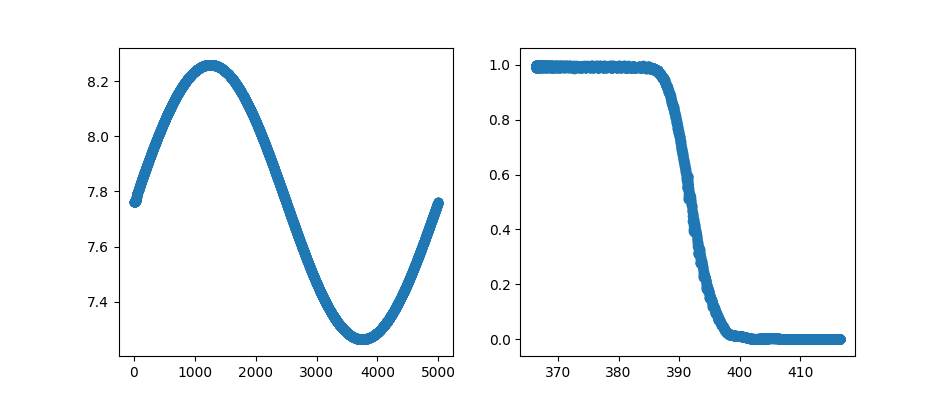

In [278]:
_,ax = plt.subplots(1,2,figsize=(9.5,4))
ax[0].scatter(range(len(pos_x)),pos_x)
pos1 = voltage_to_position(pos_x)
data1 = np.array(quad_sum)-np.min(quad_sum)
data1 = data1/np.max(data1)    
ax[1].scatter(pos1,data1)

In [221]:
ZrangeX

array([45.67586516, 45.67582193, 45.67609765, 45.6759527 , 45.67581944,
       45.67566737, 45.67585196, 45.67566113, 45.67555356, 45.67573214])

In [242]:
from scipy.optimize import curve_fit
from scipy.stats import norm

In [270]:
def get_waist(pos,pd, flip=False):

    pos1 = voltage_to_position(pos)
    if (flip):
        pos1 *= -1
    data1 = np.array(pd)-np.min(pd)
    data1 = data1/np.max(data1)    
    #noraml CDF fit
    temp_params = curve_fit(norm.cdf, pos1, data1, p0=[pos1[2500],5])[0]
    
    if (flip):
        temp_params[0] *= -1
    return temp_params

In [271]:
parX1 = []
parX2 = []
for ff in files:
    pos_x = ff.cant_pos[0]
    quad_sum = ff.quad_sum
    spin = ff.spin_data
    parX1.append(get_waist(pos_x, quad_sum, flip=True))
    parX2.append(get_waist(pos_x, spin))
parX1 = np.array(parX1)
parX2 = np.array(parX2)
ZrangeX = np.array([np.mean(ff.cant_pos[2])*10 for ff in files])

In [272]:
def beamwidth_fun(t,z,w):
    return w*np.sqrt(1+((t-z)/np.pi/w/w*1.064)**2)

Zrange = np.linspace(5,95,101)

def fit_waist(pars):
    return curve_fit(beamwidth_fun, Zrange, pars[:,1],p0=[50,5])[0]

In [273]:
pfitX1 = fit_waist(parX1)
pfitX2 = fit_waist(parX2)
print(pfitX2), print(pfitX1)

[50.62025047  2.9924093 ]
[48.65741054  3.10076456]


(None, None)

<IPython.core.display.Javascript object>


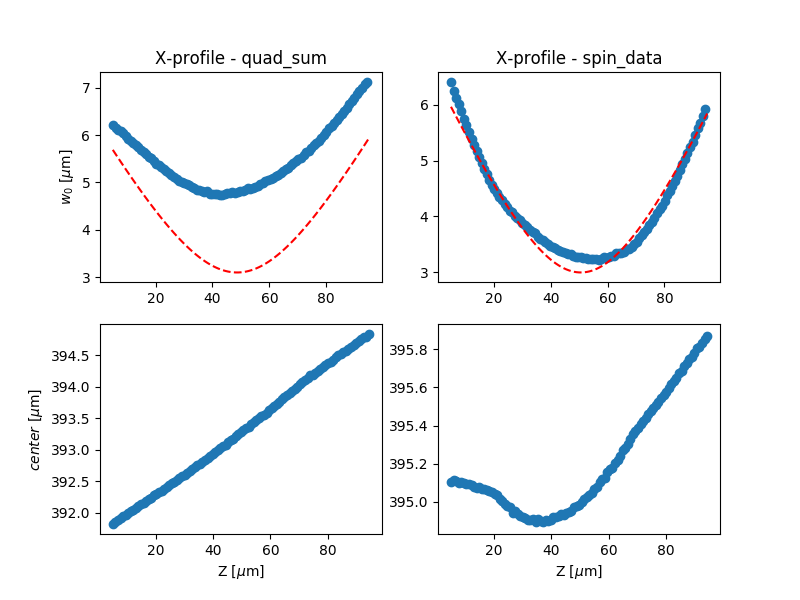

[Text(0.5, 0, 'Z [$\\mu$m]')]

In [275]:
#draw single dataset
_, ax = plt.subplots(2,2,figsize=(8,6))

ax[0,0].scatter(ZrangeX,parX1[:,1]*2)
ax[0,0].plot(Zrange,beamwidth_fun(Zrange,*pfitX1),'r--')
ax[0,0].set(title='X-profile - quad_sum', ylabel='$w_{0}$ [$\mu$m]')
ax[0,1].scatter(ZrangeX,parX2[:,1]*2)
ax[0,1].plot(Zrange,beamwidth_fun(Zrange,*pfitX2),'r--')
ax[0,1].set(title='X-profile - spin_data')

ax[1,0].scatter(ZrangeX,parX1[:,0])
ax[1,0].set(xlabel='Z [$\mu$m]', ylabel='$center$ [$\mu$m]')
ax[1,1].scatter(ZrangeX,parX2[:,0])
ax[1,1].set(xlabel='Z [$\mu$m]')

In [279]:
parY1 = []
parY2 = []
for ff in filesY:
    pos_y = ff.cant_pos[1]
    quad_sum = ff.quad_sum
    spin = ff.spin_data
    parY1.append(get_waist(pos_y, quad_sum))
    parY2.append(get_waist(pos_y, spin, flip=True))
parY1 = np.array(parY1)
parY2 = np.array(parY2)
ZrangeY = np.array([np.mean(ff.cant_pos[2])*10 for ff in filesY])

In [280]:
pfitY1 = fit_waist(parY1)
pfitY2 = fit_waist(parY2)
print(pfitY2)

[50.38327675  3.037603  ]


<IPython.core.display.Javascript object>


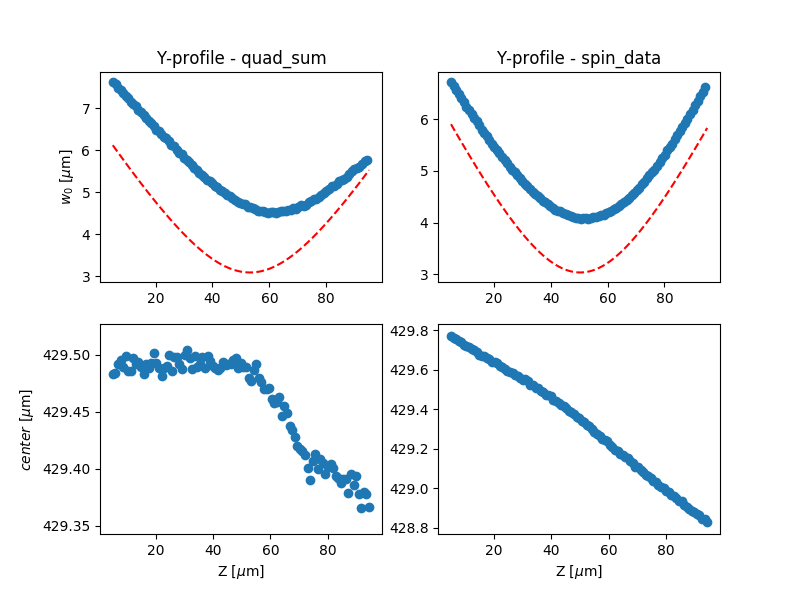

[Text(0.5, 0, 'Z [$\\mu$m]')]

In [281]:
#draw single dataset
_, ax = plt.subplots(2,2,figsize=(8,6))

ax[0,0].scatter(ZrangeY,parY1[:,1]*2)
ax[0,0].plot(Zrange,beamwidth_fun(Zrange,*pfitY1),'r--')
ax[0,0].set(title='Y-profile - quad_sum', ylabel='$w_{0}$ [$\mu$m]')
ax[0,1].scatter(ZrangeY,parY2[:,1]*2)
ax[0,1].plot(Zrange,beamwidth_fun(Zrange,*pfitY2),'r--')
ax[0,1].set(title='Y-profile - spin_data')

ax[1,0].scatter(ZrangeY,parY1[:,0])
ax[1,0].set(xlabel='Z [$\mu$m]', ylabel='$center$ [$\mu$m]')
ax[1,1].scatter(ZrangeY,parY2[:,0])
ax[1,1].set(xlabel='Z [$\mu$m]')